# Product Analytics: Customer Retention & Cohort Analysis

**Objective**  
Analyze customer purchasing behavior to understand early retention patterns and identify which acquisition cohorts show stronger post-purchase engagement.

**Key Questions**
- How quickly do customers drop off after their first purchase?
- Are certain acquisition months associated with higher early retention?
- What does this imply for product and lifecycle strategy?

In [12]:
import pandas as pd
import numpy as np
import duckdb
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

print("Environment ready")

Environment ready


## Dataset Overview

This analysis uses a public online retail transaction dataset containing:
- Transaction-level purchase records
- Customer identifiers
- Timestamps, quantities, and prices

The data spans multiple months, enabling cohort-based retention analysis.

## Data Quality & Preparation

Before analysis, the dataset is reviewed for:
- Canceled transactions
- Invalid quantities or prices
- Missing customer identifiers

These steps ensure retention metrics are based on real purchasing behavior.

In [14]:
from pathlib import Path

Path("data/raw").mkdir(parents=True, exist_ok=True)
Path("data/processed").mkdir(parents=True, exist_ok=True)

In [15]:
df = pd.read_csv("data/raw/online_retail.csv")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [16]:
df.shape

(541909, 8)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [18]:
df.isna().mean().sort_values(ascending=False)

CustomerID     0.249267
Description    0.002683
InvoiceNo      0.000000
StockCode      0.000000
Quantity       0.000000
InvoiceDate    0.000000
UnitPrice      0.000000
Country        0.000000
dtype: float64

## Data Quality & Cleaning

To ensure retention metrics reflect real customer behavior, the following records are removed:
- Canceled transactions
- Negative quantities or prices
- Transactions without a customer identifier

These steps prevent artificial inflation or distortion of retention metrics.

In [19]:
df = df[~df["InvoiceNo"].astype(str).str.startswith("C")]

In [20]:
df = df[
    (df["Quantity"] > 0) &
    (df["UnitPrice"] > 0)
]

In [21]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

In [22]:
df = df.dropna(subset=["CustomerID"])
df["CustomerID"] = df["CustomerID"].astype(int)

In [23]:
df["Revenue"] = df["Quantity"] * df["UnitPrice"]

In [24]:
df.describe(include="all")

/var/folders/mp/3trsgpw928z7bw3t1zmlkp9h0000gn/T/ipykernel_31769/1985922364.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include="all")


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
count,397884,397884,397884,397884.000000,397884,397884.000000,397884.000000,397884,397884.000000
unique,18532,3665,3877,NaN,17282,NaN,NaN,37,NaN
top,576339,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,2011-11-14 15:27:00,NaN,NaN,United Kingdom,NaN
freq,542,2035,2028,NaN,542,NaN,NaN,354321,NaN
first,NaN,NaN,NaN,NaN,2010-12-01 08:26:00,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2011-12-09 12:50:00,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,12.988238,NaN,3.116488,15294.423453,NaN,22.397000
std,NaN,NaN,NaN,179.331775,NaN,22.097877,1713.141560,NaN,309.071041
min,NaN,NaN,NaN,1.000000,NaN,0.001000,12346.000000,NaN,0.001000
25%,NaN,NaN,NaN,2.000000,NaN,1.250000,13969.000000,NaN,4.680000


In [25]:
df.to_parquet("data/processed/online_retail_clean.parquet", index=False)

## Feature Engineering (SQL)

Customer-level features are built using SQL to mirror a production analytics workflow:
- Staging transactional data
- Aggregating to customer grain
- Deriving lifecycle and value segments

This separation improves clarity and reproducibility.

In [26]:
con = duckdb.connect("data/processed/analytics.duckdb")

## SQL Modeling with DuckDB

To mirror a production analytics workflow, SQL is used for:
- Staging transactional data
- Aggregating to customer-level features
- Building cohort retention metrics

DuckDB enables local, reproducible SQL execution without external infrastructure.

In [27]:
con.execute("""
CREATE OR REPLACE TABLE retail_clean AS
SELECT *
FROM read_parquet('data/processed/online_retail_clean.parquet')
""")

In [28]:
con.execute("SELECT COUNT(*) FROM retail_clean").fetchall()

[(397884,)]

In [40]:
features_sql = open("sql/02_features.sql").read()
con.execute(features_sql)

con.execute("""
SELECT
  COUNT(*) AS customers,
  AVG(lifetime_revenue) AS avg_lifetime_revenue,
  AVG(total_orders) AS avg_orders
FROM fct_customer_features
""").df()

,customers,avg_lifetime_revenue,avg_orders
0,4338,2054.26646,4.272015


## Cohort Retention Analysis

Customers are grouped into cohorts based on the month of first purchase.
Retention is defined as making at least one purchase in a subsequent calendar month.

In [41]:
metrics_sql = open("sql/03_metrics.sql").read()
con.execute(metrics_sql)

con.execute("SELECT * FROM mart_cohort_retention LIMIT 20").df()

,cohort_month,months_since_cohort,cohort_size,retained_customers,retention_rate
0,2010-12-01,0,885,885,1.000000
1,2010-12-01,1,885,324,0.366102
2,2010-12-01,2,885,286,0.323164
3,2010-12-01,3,885,340,0.384181
4,2010-12-01,4,885,321,0.362712
5,2010-12-01,5,885,352,0.397740
6,2010-12-01,6,885,321,0.362712
7,2010-12-01,7,885,309,0.349153
8,2010-12-01,8,885,313,0.353672
9,2010-12-01,9,885,350,0.395480


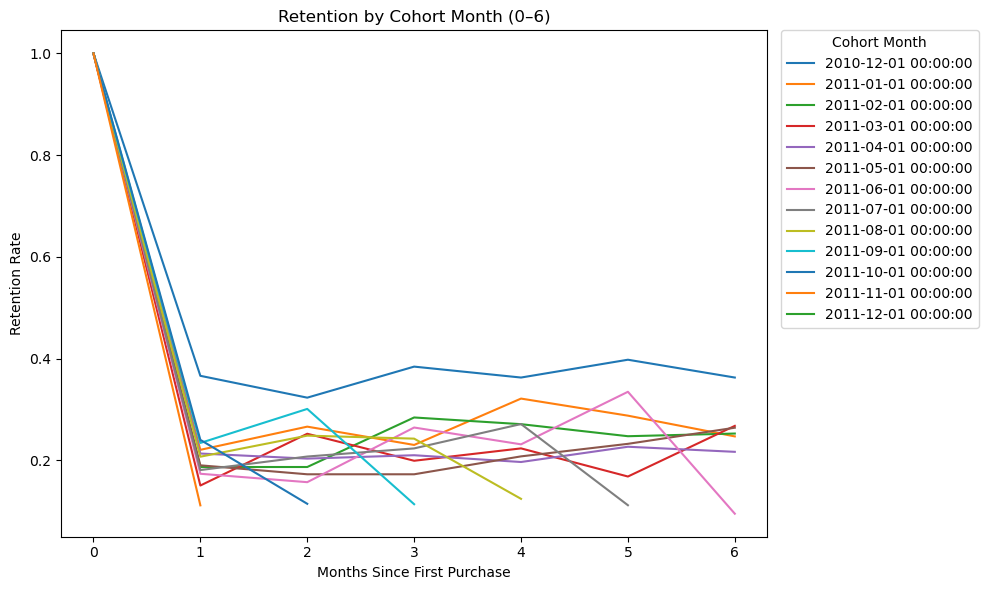

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

ret = con.execute("""
SELECT cohort_month, months_since_cohort, retention_rate
FROM mart_cohort_retention
WHERE months_since_cohort BETWEEN 0 AND 6
""").df()

ax = pivot.plot(figsize=(10,6))
ax.set_title("Retention by Cohort Month (0–6)")
ax.set_xlabel("Months Since First Purchase")
ax.set_ylabel("Retention Rate")

ax.legend(
    title="Cohort Month",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0
)

plt.tight_layout()
plt.show()

## Key Observations

- Customer retention drops sharply after the first purchase, indicating a critical early lifecycle gap.
- December acquisition cohorts exhibit higher Month-1 retention compared to most other months.
- Retention curves become noisy after Month-2, consistent with non-subscription retail behavior.

## Interpretation

Higher Month-1 retention for December cohorts reflects sustained early engagement rather than same-month repeat purchases.  
This behavior is consistent with post-holiday follow-up activity such as returns, exchanges, and gift-recipient conversions.

In [43]:
con.execute("""
WITH m1 AS (
  SELECT cohort_month, retention_rate
  FROM mart_cohort_retention
  WHERE months_since_cohort = 1
)
SELECT *
FROM m1
ORDER BY retention_rate DESC
LIMIT 3
""").df()

,cohort_month,retention_rate
0,2010-12-01,0.366102
1,2011-10-01,0.240223
2,2011-09-01,0.234114


In [50]:
con.execute("""
SELECT
  DATE_TRUNC('month', first_order_ts) AS cohort_month,
  COUNT(*) AS customers,
  AVG(days_since_last_order) AS avg_days_since_last
FROM fct_customer_features
GROUP BY 1
ORDER BY 1
""").df()

,cohort_month,customers,avg_days_since_last
0,2010-12-01,885,97.374011
1,2011-01-01,417,117.247002
2,2011-02-01,380,126.186842
3,2011-03-01,452,127.216814
4,2011-04-01,300,126.330000
5,2011-05-01,284,107.911972
6,2011-06-01,242,94.169421
7,2011-07-01,188,87.952128
8,2011-08-01,169,73.650888
9,2011-09-01,299,55.070234


## Recommendations

- Prioritize initiatives that improve first-to-second purchase conversion.
- Focus lifecycle experiments within the first 30 days after acquisition.
- Further segment early retention by customer value to guide targeting.